In [100]:
# AUTHOR Christian Dansereau 2016

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import scipy.io
import os
import nibabel as nib
from nibabel.affines import apply_affine
from nilearn import plotting
import numpy.linalg as npl

# Load data

In [101]:
#seed_data = pd.read_csv('20160128_AD_Decrease_Meta_Christian.csv')

template_036= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale036.nii.gz')
template_020= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale020.nii.gz')
template_012= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale012.nii.gz')
template_007= nib.load('/home/cdansereau/data/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale007.nii.gz')

scale = '36'

if scale == '7':
    template = template_007
else:
    template = template_036

#seed_data = pd.read_csv('20160205_AD_Decrease_Meta_Final.csv')
#seed_data = pd.read_csv('20160129_AD_Increase_Meta_Final.csv')

#seed_data = pd.read_csv('20160205_MCI_Decrease_Meta_Final.csv')
seed_data = pd.read_csv('20160204_MCI_Increase_Meta_Final.csv')


#output_stats = 'AD_decrease_scale'+scale+'_stats.mat'
#output_vol   = 'AD_decrease_ratio'+scale+'_vol.nii.gz'
#output_stats = 'AD_increase_scale'+scale+'_stats.mat'
#output_vol   = 'AD_increase_ratio_scale'+scale+'_vol.nii.gz'

#output_stats = 'MCI_decrease_scale'+scale+'_stats.mat'
#output_vol   = 'MCI_decrease_ratio_scale'+scale+'_vol.nii.gz'
output_stats = 'MCI_increase_scale'+scale+'_stats.mat'
output_vol   = 'MCI_increase_ratio_scale'+scale+'_vol.nii.gz'

In [102]:
seed_data

,PMID,Author,Year,subjects,x,y,z,Contrast,Direction
0,19765560,Bai,2009,56,-9.00,57.00,-12.00,MCI,Increase
1,19765560,Bai,2009,56,3.00,57.00,-15.00,MCI,Increase
2,19765560,Bai,2009,56,-6.00,36.00,33.00,MCI,Increase
3,19765560,Bai,2009,56,-39.00,33.00,-18.00,MCI,Increase
4,19765560,Bai,2009,56,-39.00,-18.00,-30.00,MCI,Increase
5,20930266,Bai,2011,44,-15.00,-45.00,-48.00,MCI,Increase
6,20930266,Bai,2011,44,-15.00,-45.00,-45.00,MCI,Increase
7,20930266,Bai,2011,44,3.00,-57.00,12.00,MCI,Increase
8,20930266,Bai,2011,44,-3.00,-63.00,9.00,MCI,Increase
9,21982164,Jin,2012,16,8.00,46.00,36.00,MCI,Increase


## Get the number of coordinates reported for each network

In [103]:
from numpy.linalg import norm
# find the closest network to the coordo
def get_nearest_net(template,world_coor):
    list_coord = np.array(np.where(template.get_data()>0))
    mni_coord = apply_affine(template.get_affine(),list_coord.T)
    distances = norm(mni_coord-np.array(world_coor),axis=1)
    #print distances.shape
    idx_nearest_net = np.where(distances == np.min(distances))[0][0]
    return int(template.get_data()[list_coord[:,idx_nearest_net][0],list_coord[:,idx_nearest_net][1],list_coord[:,idx_nearest_net][2]])
    
#get_nearest_net(template,[-15,-10,-10])
# Convert from world MNI space to the EPI voxel space
def get_world2vox(template, mni_coord):
    return np.round(apply_affine(npl.inv(template.get_affine()),mni_coord)+[1])
    
network_votes = np.zeros((np.max(template.get_data().flatten()),1))[:,0]
network_votes

# get the voxel coordinates of the MNI seeds
mni_space_targets = seed_data[['x','y','z']].values
vox_corrd = get_world2vox(template,mni_space_targets)
votes = []
n_outofbrain=0
for i in range(vox_corrd.shape[0]):
    net_class = template.get_data()[vox_corrd[i,0],vox_corrd[i,1],vox_corrd[i,2]]
    if net_class==0:
        n_outofbrain+=1
        votes.append(get_nearest_net(template,[mni_space_targets[i,0],mni_space_targets[i,1],mni_space_targets[i,2]]))
    else:
        votes.append(net_class)

print('Out of brain coordinates: '+ str(n_outofbrain))
votes = np.array(votes)    

# take one vote for each study only
uni_pmid = np.unique(seed_data['PMID'])
votes.shape
frequency_votes=np.zeros((len(uni_pmid),len(network_votes)))
#for i in range(len(uni_pmid)):
#    frequency_votes = np.hstack((frequency_votes,np.unique(votes[(seed_data['PMID']==uni_pmid[i]).values])))
for i in range(len(uni_pmid)):
    aa = votes[(seed_data['PMID']==uni_pmid[i]).values]
    for j in aa:
        frequency_votes[i,j-1] = (aa == j).sum()/float(len(aa))
print frequency_votes


# compile the stats for each network
#for i in range(1,len(network_votes)+1):
#    network_votes[i-1] = np.mean(frequency_votes==i)
network_votes = np.mean(frequency_votes,axis=0)
print network_votes 
#vox_corrd[np.array(votes)==5,:]

Out of brain coordinates: 6
[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.2         0.          0.
   0.          0.          0.          0.4         0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.2         0.          0.          0.          0.          0.2         0.
   0.        ]
 [ 0.          0.          0.          0.25        0.5         0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.25        0.          0.          0.
   0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.5
   0.

In [104]:
get_nearest_net(template,[-24,-10, 22])

8

In [105]:
def gen1perm(n_seeds,proba):
    ratio_votes_1study = np.zeros_like(proba)
    perm_votes = np.random.choice(range(0,len(proba)),size=(n_seeds,1),p=proba)
    for j in perm_votes:
        ratio_votes_1study[j] = (perm_votes == j).sum()/float(len(perm_votes))
    return ratio_votes_1study

# check if the proba is respected 
#print proba_networks
#gen1perm(10000,proba_networks)
#ange(0,len(proba_networks))

## Generate random coordinates
#### The assigned coodinates are generated for each network witha proability equivalent to there volume size compare to the total volume of the brain

In [106]:
'''
from numpy.random import permutation
def permute_table(frequency_votes,n_iter):
    h0_results = []
    for n in range(n_iter):
        perm_freq = frequency_votes.copy()
        #print perm_freq
        for i in range(perm_freq.shape[0]):
            perm_freq[i,:] = permutation(perm_freq[i,:])
        #print perm_freq
        h0_results.append(np.mean(perm_freq,axis=0))
    return np.array(h0_results).T
'''
def compute_freq(votes,data_ratio_votes,seed_data,proba):
    # take one vote for each study only
    uni_pmid = np.unique(seed_data['PMID'])
    ratio_votes=np.zeros((data_ratio_votes.shape[0],data_ratio_votes.shape[1],10000))
    for idx_perm in range(ratio_votes.shape[-1]):
        #    frequency_votes = np.hstack((frequency_votes,np.unique(votes[(seed_data['PMID']==uni_pmid[i]).values])))
        for i in range(len(uni_pmid)):
            aa = votes[(seed_data['PMID']==uni_pmid[i]).values]
            n_seeds = len(aa)
            ratio_votes[i,:,idx_perm] = gen1perm(n_seeds,proba)
        #print ratio_votes.shape
    # compute the frequency
    freq_data = np.mean(ratio_votes,axis=0)
        
    for i in range(freq_data.shape[0]):
        freq_data[i,:] = np.sort(freq_data[i,:])[::-1]
        
    return freq_data

# Total volume of the brain
total_volume = np.sum(template.get_data()>0)

# compute the proba of each network
proba_networks=[]
for i in range(1,len(network_votes)+1):
    proba_networks.append(np.sum(template.get_data()==i)/(total_volume*1.))
proba_networks = np.array(proba_networks)
print np.sum(proba_networks)
print proba_networks

# generate random values 
'''
def gen_rnd_hits(proba,n_seeds):
    results_h0 =  np.random.choice(range(0,len(proba)),size=(n_seeds,1000),p=proba)
    #results_h0 = permute_table(frequency_votes,1000)
    print results_h0.shape
    ditributions = []
    for i in range(frequency_votes.shape[1]):
        results_h0[i,:] = np.sort(results_h0[i,:])[::-1]
        #ditributions.append(one_way_pdf)   
    #return ditributions
    return results_h0
'''
#dist_data = gen_rnd_hits(proba_networks,np.sum(network_votes))
dist_data = compute_freq(votes,frequency_votes,seed_data,proba_networks)

1.0
[ 0.01292611  0.01787506  0.01579858  0.01342793  0.01671569  0.01412009
  0.01960547  0.02496972  0.01775394  0.02441599  0.01770202  0.02941685
  0.02853435  0.01915556  0.02929573  0.03292957  0.03163177  0.02310088
  0.02479668  0.03317183  0.04075099  0.02912269  0.02611178  0.02978024
  0.04455788  0.02891504  0.01429313  0.02278941  0.02957259  0.03215089
  0.0433293   0.03299879  0.03421007  0.03739401  0.04514622  0.06153314]


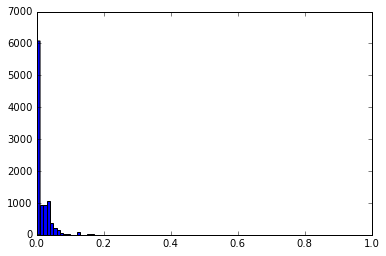

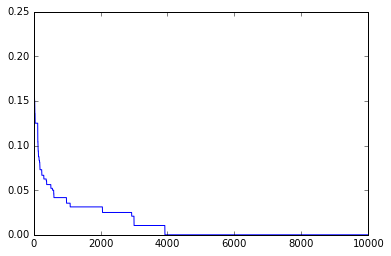

In [107]:
plt.figure()
plt.hist(dist_data[0],bins=np.arange(0,1,.01))
plt.figure()
plt.plot(dist_data[0].T)

## Generate the p-values for each network

[ 0.          0.          0.0625      0.03125     0.0625      0.          0.
  0.08333333  0.          0.03125     0.          0.09791667  0.          0.0625
  0.          0.          0.          0.05        0.          0.          0.
  0.025       0.          0.          0.02083333  0.          0.          0.
  0.03541667  0.15        0.05        0.13958333  0.03125     0.025       0.
  0.04166667]
[0.39216078392160786, 0.49085091490850913, 0.040295970402959701, 0.11118888111188881, 0.042595740425957401, 0.41235876412358763, 0.53054694530546942, 0.042395760423957603, 0.48525147485251474, 0.25767423257674232, 0.49245075492450757, 0.041895810418958103, 0.67663233676632339, 0.058094190580941903, 0.6793320667933207, 0.71482851714828521, 0.6987301269873013, 0.1414858514148585, 0.60693930606939306, 0.72652734726527346, 0.78512148785121483, 0.43065693430656932, 0.63503649635036497, 0.68763123687631234, 0.70842915708429155, 0.66023397660233973, 0.42205779422057793, 0.58594140585941401, 0.2909

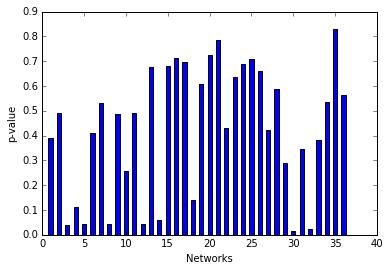

In [108]:
def getpval_old(nhit,dist_data):
    distribution_val =  np.histogram(dist_data,bins=np.arange(0,1,0.01))
    idx_bin = np.where((distribution_val[1]>=round(nhit,2)) & (distribution_val[1]<=round(nhit,2)))[0][0]
    #print distribution_val[1]
    return (np.sum(distribution_val[0][idx_bin:-1])+1)/(dist_data.shape[0]+1.)

def getpval(target,dist_data):
    dist_sorted = np.sort(np.copy(dist_data))
    b = np.sum(dist_sorted > target)
    #print b
    #print dist_data.shape[0]
    #print distribution_val[1]
    return ((b+1.)/(dist_data.shape[0]+1.))

print network_votes

pval_results=[]
for i in range(0,len(dist_data)):
    pval_results.append(getpval(network_votes[i],dist_data[i,:]))
    
print pval_results
plt.figure()
plt.bar(np.arange(1,len(pval_results)+1),pval_results,width=0.5,align='center')
plt.xlabel('Networks')
plt.ylabel('p-value')

### Map the p-values to the template

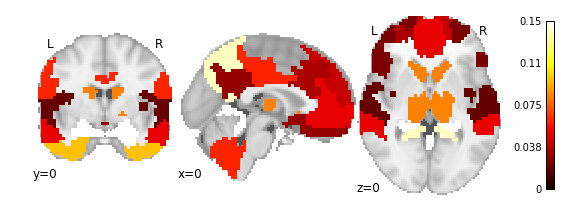

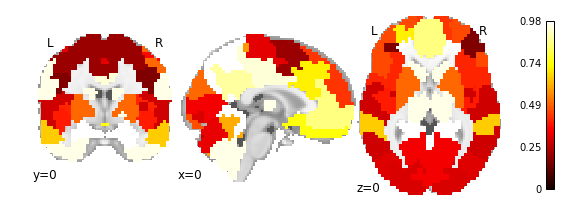

In [109]:
from proteus.matrix import tseries as ts
hitfreq_vol = ts.vec2map(network_votes,template)
pval_vol = ts.vec2map(1-np.array(pval_results),template)
plt.figure()
plotting.plot_stat_map(hitfreq_vol,cut_coords=(0,0,0),draw_cross=False)
plt.figure()
plotting.plot_stat_map(pval_vol,cut_coords=(0,0,0),draw_cross=False)


#### FDR correction of the p-values

In [110]:
# correct for FRD
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

fdr_test,fdr_pval=fdrcorrection0(pval_results,alpha=0.05)
print network_votes
print fdr_test
print fdr_pval

[ 0.          0.          0.0625      0.03125     0.0625      0.          0.
  0.08333333  0.          0.03125     0.          0.09791667  0.          0.0625
  0.          0.          0.          0.05        0.          0.          0.
  0.025       0.          0.          0.02083333  0.          0.          0.
  0.03541667  0.15        0.05        0.13958333  0.03125     0.025       0.
  0.04166667]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False]
[ 0.76926425  0.76926425  0.25557444  0.50034997  0.25557444  0.76926425
  0.76926425  0.25557444  0.76926425  0.76926425  0.76926425  0.25557444
  0.76926425  0.29877012  0.76926425  0.76926425  0.76926425  0.56594341
  0.76926425  0.76926425  0.80755353  0.76926425  0.76926425  0.76926425
  0.76926425  0.76926425  0.76926425  0.76926425  0.76926425  0.25557444
  0.76926425

In [111]:
# save the results

path_output = '/home/cdansereau/git/Projects/metaad/maps_results/'
stats_results = {'Hits':network_votes ,'pvalues':pval_results,'fdr_test':fdr_test,'fdr_pval':fdr_pval,'n_outofbrain':n_outofbrain}
scipy.io.savemat(path_output + output_stats, stats_results)
hitfreq_vol.to_filename(os.path.join(path_output,output_vol))
#hitfreq_vol.to_filename(os.path.join('/home/cdansereau/git/Projects/metaad/maps_results/','AD_pval_vol.nii.gz'))